# Linear Regression

## Preliminary Data Wrangling

In [1]:
%matplotlib inline
from IPython.core.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")
import pandas as pd
import numpy as np
df = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')


# Remove % sign from DtI Ratio and interest rate
df['Debt.To.Income.Ratio'] = df['Debt.To.Income.Ratio'].apply(lambda x: x[:-1]).astype('float64')
df['Interest.Rate'] = df['Interest.Rate'].apply(lambda x: x[:-1]).astype('float64')

#Bucket categorical variables as float. Float type will allow easy removal of outliers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.State = le.fit_transform(df.State).astype('float64')
df['Home.Ownership'] = le.fit_transform(df['Home.Ownership']).astype('float64')


#extract float val from string
def numonly(string):
    res = ''
    for x in string:
        if x.isdigit():
            res = res+x
    return int(res)
df.loc[:,'Loan.Length'] = df['Loan.Length'].apply(numonly).astype('float64')

#average te FICO Range/ convert to float
def noline(string):
    x = string.split('-')
    c = 0
    for y in x:
        y=int(y)
        c+=y
    return c/2
df.loc[:,'FICO.Range'] = df['FICO.Range'].apply(noline).astype('float64')


#delete superfluous features
del df['Loan.Purpose']
del df['Employment.Length']


#drop NaN values and remove outliers
df = df.dropna()
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [2]:
df.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months
81174,20000,20000.0,8.90,36.0,14.90,36.0,0.0,6541.67,737.0,14.0,14272.0,2.0
99592,19200,19200.0,12.12,36.0,28.36,38.0,0.0,4583.33,717.0,12.0,11140.0,1.0
80059,35000,35000.0,21.98,60.0,23.81,4.0,0.0,11500.00,692.0,14.0,21977.0,1.0
15825,10000,9975.0,9.99,36.0,14.30,15.0,0.0,3833.33,697.0,10.0,9346.0,0.0
33182,12000,12000.0,11.71,36.0,18.78,27.0,4.0,3195.00,697.0,11.0,14469.0,0.0


## Visual Exploration

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Distrubution Plot and Histogram of FICO
Shows a slightly skewed, but normal distribution

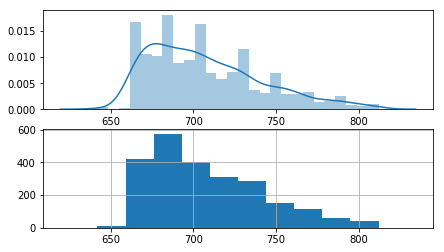

In [4]:
fig = plt.figure(figsize = (7,4))

ax1 = fig.add_subplot(211)
sns.distplot(df['FICO.Range'])
ax2 = fig.add_subplot(212,sharex = ax1)
df['FICO.Range'].hist()

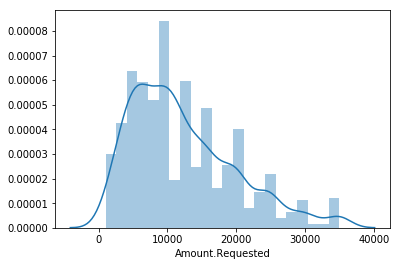

In [5]:
sns.distplot(df['Amount.Requested'])

### Box Plot

Shows a clear negative relation between interest rate and Fico Score.

C:\Users\Harrison\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'                          ')

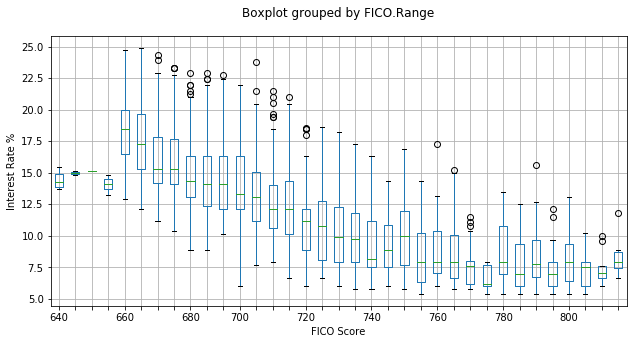

In [6]:
fig = plt.figure()
x = df.boxplot('Interest.Rate',  'FICO.Range', figsize=(10,5))
x.set_xticklabels(['640','','','','660','','','','680','','','700','','','',
  '720','','','','740','','','','760','','','','780','','','','800','','','','820','','','','840'])
x.set_xlabel('FICO Score')
x.set_ylabel('Interest Rate %')
x.set_title('                          ')

From here we need to make a pairplot of all of the interesting variables that might effect interest rate. We already determined that FICO Score has an effect on int rate. Also, consider the following

amount requested

FICO Score

Monthly Income

Loan Length

Interest Rate


from here you should see a relation to FICO Score and Loan Amount

In [7]:
subdf = df.drop([ 'Amount.Funded.By.Investors', 
        'Debt.To.Income.Ratio', 'State', 'Home.Ownership',
       'Open.CREDIT.Lines',
       'Revolving.CREDIT.Balance', 'Inquiries.in.the.Last.6.Months'], axis=1)
subdf.head()

,Amount.Requested,Interest.Rate,Loan.Length,Monthly.Income,FICO.Range
81174,20000,8.90,36.0,6541.67,737.0
99592,19200,12.12,36.0,4583.33,717.0
80059,35000,21.98,60.0,11500.00,692.0
15825,10000,9.99,36.0,3833.33,697.0
33182,12000,11.71,36.0,3195.00,697.0


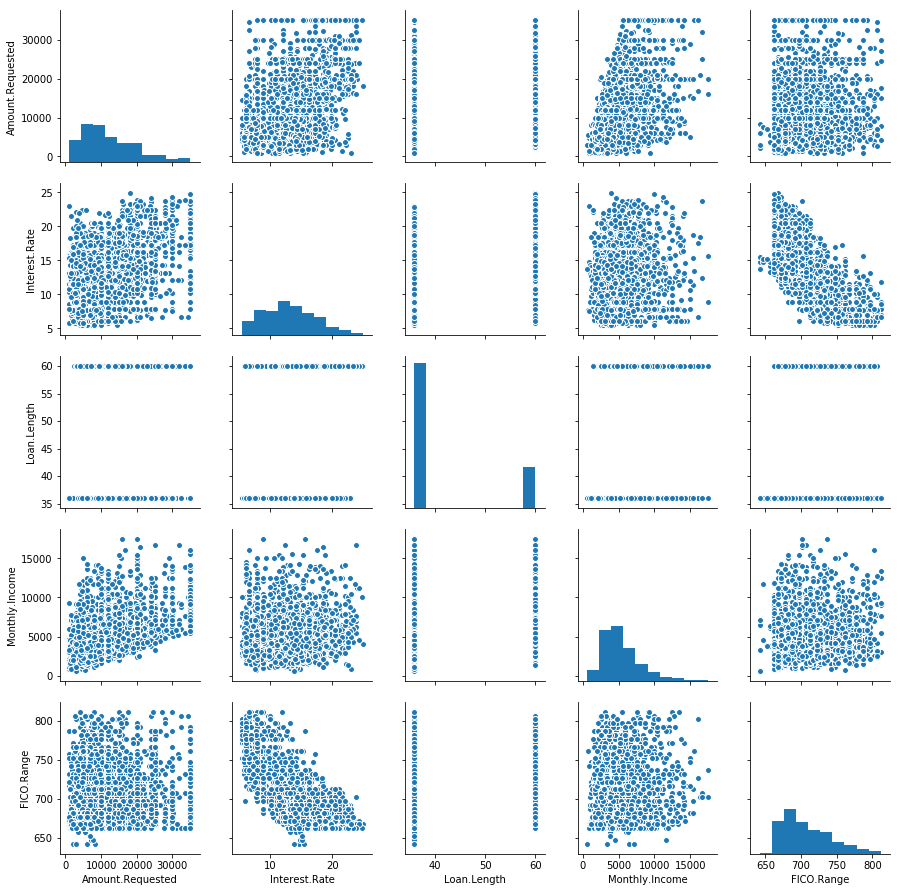

In [8]:
sns.pairplot(subdf)

Of interest might be Interest rate (with a slightly positive linear distribution.) So we narrow our interesting values down to FICO Score and Amount Requested.

## Time to Model

Lets start with OLE, I will not create a test set, but instead choose training accuracy since this is pretty rough and dirty.

In [9]:
import sklearn.linear_model as lm
x1 = df['FICO.Range'].values.reshape(-1,1)
x2 = df['Amount.Requested'].values.reshape(-1,1)
x_input = np.column_stack([x1,x2]) 


In [10]:
OLE = lm.LinearRegression()
OLE.fit(x_input, df['Interest.Rate'])
y_pred = OLE.predict(x_input)
OLE.score(x_input, df['Interest.Rate'])

0.66372612060997715

In [11]:
from sklearn.metrics import r2_score


#Computing the R^2 statistic for our regressor.
r = r2_score(df['Interest.Rate'], y_pred)
print("coefficients",OLE.coef_,"and the intercept is:", OLE.intercept_)
print(r)

coefficients [-0.08983563  0.00021486] and the intercept is: 73.9662220521
0.66372612061


You Learn something new every day, the default score method for OLE regressor is already the R$^{2}$ statistic.

Now we need to research how to plot the residuals to look for heteroscedesticity and nonlinearity.


## Lets Plot that in Three Dimensions


In [12]:
import os
os.chdir('C:\\Users\\Harrison\\Documents\\GitHub\\ML-Notes')

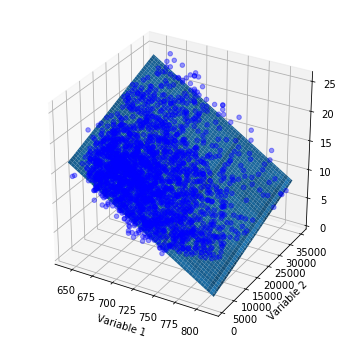

In [13]:
import VisualFuncs as vf
vf.ThreeD_VDR([0,1], x_input, df['Interest.Rate'], OLE)

## Hold Up!!!

https://medium.com/@dhwajraj/learning-python-regression-analysis-part-9-tests-and-validity-for-regression-models-78dcd5cde3a1

Gives a stats model that is way more informative, providing all of the statistics that I might need if I wanted tot do serious linear regression. Sklearn does not seem very full bodied.

Specifically I want to know F and pstatistics before I actually make the model, so I can devide what variables are relevan, and which variables break assumptions.


In [14]:
import statsmodels.formula.api as sm
subdf1 = subdf.drop(['Loan.Length', 'Monthly.Income'], axis =1)

In [15]:
subdf1.head()

,Amount.Requested,Interest.Rate,FICO.Range
81174,20000,8.90,737.0
99592,19200,12.12,717.0
80059,35000,21.98,692.0
15825,10000,9.99,697.0
33182,12000,11.71,697.0


In [16]:
subdf1.columns = ['Amount', 'Interest', 'FICO']
olson = sm.ols(formula = 'Interest ~ Amount + FICO', data = subdf1)
res = olson.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Interest   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     2342.
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:16:20   Log-Likelihood:                -5458.3
No. Observations:                2376   AIC:                         1.092e+04
Df Residuals:                    2373   BIC:                         1.094e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.9662      1.022     72.364      0.000      71.962      75.971
Amount         0.0002   6.49e-06     33.105      0.000       0.000       0.000
FICO          -0.0898      0.001    -62.081      0.000      -0.093      -0.087
==============================================================================
Omnibus:                       68.057   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.427
Skew:                           0.367   Prob(JB):                     5.66e-18
Kurtosis:                       3.513   Cond. No.                     2.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Calculate the correlation coefficient with np.corrcoef
Remember that perfect colinearity is either -1 or 1

In [17]:
np.corrcoef(subdf1.iloc[:,[0,2]], rowvar = 0)

array([[ 1.        ,  0.07042253],
       [ 0.07042253,  1.        ]])

## Calculate Multicollinearity with an eigenvector Matrix

In [18]:
subdf.head()

,Amount.Requested,Interest.Rate,Loan.Length,Monthly.Income,FICO.Range
81174,20000,8.90,36.0,6541.67,737.0
99592,19200,12.12,36.0,4583.33,717.0
80059,35000,21.98,60.0,11500.00,692.0
15825,10000,9.99,36.0,3833.33,697.0
33182,12000,11.71,36.0,3195.00,697.0


In [19]:
corr = np.corrcoef(subdf.iloc[:,[0,2,3,4]],rowvar = 0)
corr

array([[ 1.        ,  0.42571128,  0.44383172,  0.07042253],
       [ 0.42571128,  1.        ,  0.11660692,  0.01665865],
       [ 0.44383172,  0.11660692,  1.        ,  0.10645136],
       [ 0.07042253,  0.01665865,  0.10645136,  1.        ]])

In [20]:
W,V = np.linalg.eig(corr)
W

array([ 1.69435837,  0.44036952,  1.01127946,  0.85399264])

If at least one of the eigenvalues of the above correlation matrix is close to zero then we can say that multicollinearity exists in the dataset. (ie the effect of one variable is a linear combination of multiple other variables.)


A eigen value close to zero  shows minimal variation in the data orthagonal with other eigen vectors. Essentially the eigen value close to zero shows an eigenvector is not orthagonl to other eigen vectors.

## Handling Multicollinearity
Though we dont have it here, it will be useful to alk about this issue.

### Idea 1: Remove the Variables
Look at the eigenvectors generated above.

In [21]:
V # all of the eigenvectors

array([[-0.66346124, -0.73867787, -0.10655626,  0.05310322],
       [-0.50009595,  0.45966032, -0.3842966 , -0.625246  ],
       [-0.53274266,  0.49280628,  0.22483359,  0.65021311],
       [-0.16096114, -0.01446965,  0.88905104, -0.42833444]])

In [22]:
W # Eigenvalues

array([ 1.69435837,  0.44036952,  1.01127946,  0.85399264])

Amount Requested --Loan Length --MonthlyIncome----FICO

Each column is an eigenvector that corresponds to the input variables above.

First select the eigenvectors whose value is close to zero. Now ignore the columns with values that come consistently close to zero. All of the remaining columns are strongly correlated with each other and any one of them would capture the effect of the others.

In [23]:
corr2 = np.corrcoef(df, rowvar =0)
W, V = np.linalg.eig(corr2)
W


array([ 3.13366356,  1.84997449,  0.02657486,  0.12458023,  1.47406496,
        0.37837113,  0.57290804,  0.62604267,  1.12143346,  0.78832761,
        1.00564095,  0.89841804])

Even after dumping all the variables in theres seems to be very little evidence of collinearity

## How Do We Plot Residuals????

Errors should have a normal distribution

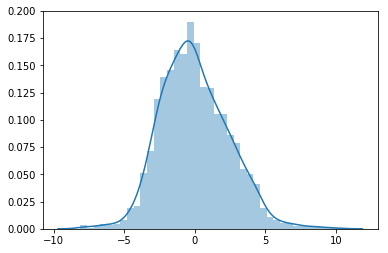

In [24]:
residuals = df['Interest.Rate'].values.reshape(-1,1) - y_pred.reshape(-1,1)
sns.distplot(residuals)

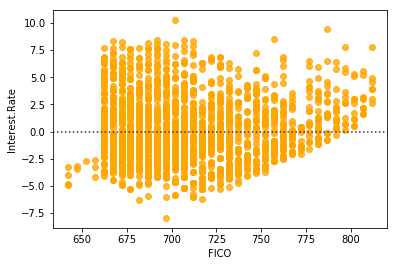

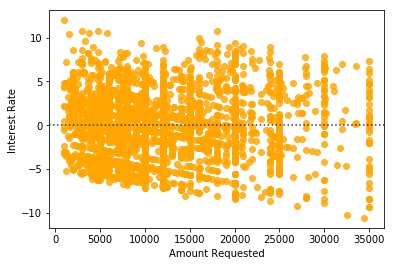

In [25]:
names = ['FICO', 'Amount Requested']
for i in range(2):
    plt.figure(i)
    sns.residplot(x_input[:,i], df['Interest.Rate'], color = 'orange')
    plt.xlabel(names[i])

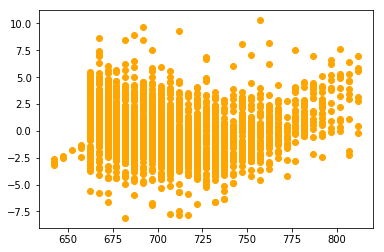

In [26]:
plt.scatter(df['FICO.Range'], residuals, color = 'orange')

Something is going on with the FICO Score. Might be a nonlinear relation.

## Regularization

To offset some of the weirdness that we just found, a regularization term might be helpful. Since there are only two features and no correlation, we should do a Ridge as primary and do a  LASSO as backup to see if we can improve performance

### Ridge

In [27]:
ridge = lm.RidgeCV()
ridge.fit(x_input, df['Interest.Rate'])
y_pred2 = ridge.predict(x_input)
scosco = ridge.score(x_input, df['Interest.Rate'])
print('OLS Score:', r, 'Ridge Score:', scosco)

OLS Score: 0.66372612061 Ridge Score: 0.663726120601


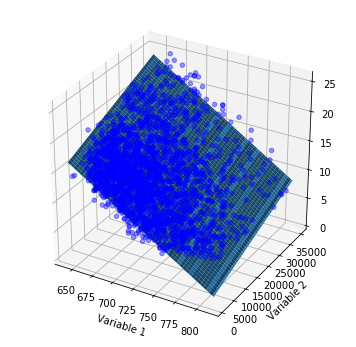

In [28]:
vf.ThreeD_VDR([0,1], x_input, df['Interest.Rate'], ridge)

### LASSO
 L1 regularization

In [33]:
lasso = lm.Lasso()
lasso.fit(x_input, df['Interest.Rate'])
y_pred2 = lasso.predict(x_input)
scosco2 = lasso.score(x_input, df['Interest.Rate'])
print('OLS Score:', r, 'LASSO Score:', scosco2)

OLS Score: 0.66372612061 LASSO Score: 0.663676292829


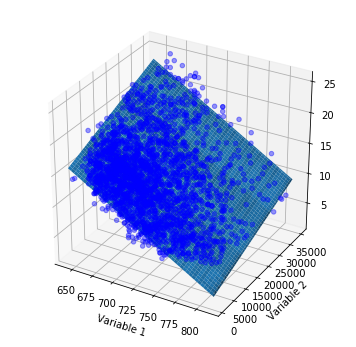

In [30]:
vf.ThreeD_VDR([0,1], x_input, df['Interest.Rate'], lasso)

### Elastic Net

In [38]:
elast = lm.ElasticNet(alpha=1.0)
elast.fit(x_input, df['Interest.Rate'])
y_pred2 = elast.predict(x_input)
scosco3 = elast.score(x_input, df['Interest.Rate'])
print('OLS Score:', r, 'Elastic Net Score:', scosco3)

OLS Score: 0.66372612061 Elastic Net Score: 0.663711338463


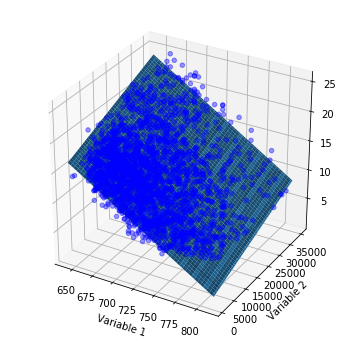

In [32]:
vf.ThreeD_VDR([0,1], x_input, df['Interest.Rate'], elast)